In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

AIME_metadata_path = "/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Sample Audios/trimmedAIME_metadata.csv"

AIME_metadata = pd.read_csv(AIME_metadata_path)
AIME_metadata.head()

Mounted at /content/drive


,id,file_name,sampling_rate,duration_seconds,model,description
0,4501,04501_trimmed.wav,48000,7.0,Udio,"ambient, blues, piano"
1,4502,04502_trimmed.wav,48000,7.0,Udio,"ambient, breakbeat, trance"
2,4503,04503_trimmed.wav,48000,7.0,Udio,"ambient, calm, happy"
3,4504,04504_trimmed.wav,48000,7.0,Udio,"ambient, calm, soft"
4,4505,04505_trimmed.wav,48000,7.0,Udio,"ambient, calm, space"


In [ ]:
file_names = AIME_metadata["file_name"]
models = AIME_metadata["model"]

In [ ]:
import numpy as np
import json

AIME_embeddings_npy_path = "/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Sample Audios/CLAP_AIME_Embeddings.npy"
AIME_embeddings = np.load(AIME_embeddings_npy_path)

with open("/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Sample Audios/CLAP_AIME_Embeddings.json", "r") as f:
    AIME_json_metadata = json.load(f)

In [ ]:
model_list = []
count = 0
for model in models:
  if model not in model_list:
    model_list.append(model)
    count += 1
print(count)

13


In [ ]:
file_to_index = {item["file_name"]: idx for idx, item in enumerate(AIME_json_metadata)}
ordered_indices = [file_to_index[file_name] for file_name in AIME_metadata["file_name"]]
ordered_embeddings = AIME_embeddings[ordered_indices]

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
AIME_metadata['model_encoded'] = label_encoder.fit_transform(AIME_metadata['model'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

numerical_labels = AIME_metadata['model_encoded'].values
print("Numerical Labels:", numerical_labels)

reverse_mapping = {v: k for k, v in label_mapping.items()}
print("Reverse Mapping:", reverse_mapping)


Label Mapping: {'AudioLDM 2 Large': 0, 'AudioLDM 2 Music': 1, 'MTG-Jamendo': 2, 'MusicGen Large': 3, 'MusicGen Medium': 4, 'MusicGen Small': 5, 'Mustango': 6, 'Riffusion': 7, 'Stable Audio v1': 8, 'Stable Audio v2': 9, 'Suno v3': 10, 'Suno v3.5': 11, 'Udio': 12}
Numerical Labels: [12 12 12 ... 11 11 11]
Reverse Mapping: {0: 'AudioLDM 2 Large', 1: 'AudioLDM 2 Music', 2: 'MTG-Jamendo', 3: 'MusicGen Large', 4: 'MusicGen Medium', 5: 'MusicGen Small', 6: 'Mustango', 7: 'Riffusion', 8: 'Stable Audio v1', 9: 'Stable Audio v2', 10: 'Suno v3', 11: 'Suno v3.5', 12: 'Udio'}


In [ ]:
np.savez("/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Sample Audios/AIME_Model_Classificatiion.npz", embeddings=ordered_embeddings, labels=numerical_labels)

In [ ]:
print(ordered_indices[:10])
print(file_names[:10])
print(models[:10])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
0    04501_trimmed.wav
1    04502_trimmed.wav
2    04503_trimmed.wav
3    04504_trimmed.wav
4    04505_trimmed.wav
5    04506_trimmed.wav
6    04507_trimmed.wav
7    04508_trimmed.wav
8    04509_trimmed.wav
9    04510_trimmed.wav
Name: file_name, dtype: object
0    Udio
1    Udio
2    Udio
3    Udio
4    Udio
5    Udio
6    Udio
7    Udio
8    Udio
9    Udio
Name: model, dtype: object


In [ ]:
saved_mapping = np.load("/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/Sample Audios/AIME_Model_Classificatiion.npz")
if np.allclose(AIME_embeddings, saved_mapping["embeddings"]):
  print("Embeddings are the same")
else:
  print("Embeddings are different")

Embeddings are the same


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class EmbeddingDataset(Dataset):
    """
    A PyTorch Dataset class for embeddings and labels.

    Args:
        embeddings (numpy.ndarray): The embeddings (2D array of shape [num_samples, embedding_dim]).
        labels (numpy.ndarray): The corresponding labels (1D array of shape [num_samples]).
    """
    def __init__(self, embeddings, labels):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(AIME_embeddings, numerical_labels, test_size=0.2, random_state=42, stratify=numerical_labels)

# Create Dataset objects
train_dataset = EmbeddingDataset(X_train, y_train)
test_dataset = EmbeddingDataset(X_test, y_test)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.optim as optim

class MultiClassNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MultiClassNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer with raw scores
        return x

In [ ]:
class EnhancedMultiClassNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(EnhancedMultiClassNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),  # First hidden layer
            nn.ReLU(),
            nn.BatchNorm1d(512),  # Batch normalization
            nn.Dropout(0.3),  # Regularization
            nn.Linear(512, 256),  # Second hidden layer
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),  # Output layer
        )

    def forward(self, x):
        return self.fc(x)


In [ ]:
import torch.nn as nn
class ImprovedMultiClassNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ImprovedMultiClassNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, num_classes)  # Output layer
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define training function
def train_and_evaluate_model(model, train_loader, test_loader, num_epochs=10, learning_rate=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        epoch_loss = 0.0

        for embeddings, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Store average loss for the epoch
        train_losses.append(epoch_loss / len(train_loader))

        # Evaluation Phase
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for embeddings, labels in test_loader:
                outputs = model(embeddings)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate and store accuracy for the epoch
        test_accuracy = correct / total
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}: Loss = {train_losses[-1]:.4f}, Test Accuracy = {test_accuracy:.4f}")

    return train_losses, test_accuracies

In [ ]:
def plot_training_results(train_losses, test_accuracies):
  plt.figure(figsize=(12, 6))

  # Plot Training Loss
  plt.subplot(1, 2, 1)
  plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training Loss Over Epochs")
  plt.legend()

  # Plot Testing Accuracy
  plt.subplot(1, 2, 2)
  plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label="Testing Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Testing Accuracy Over Epochs")
  plt.legend()

  plt.tight_layout()
  plt.show()


In [ ]:
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for embeddings, labels in test_loader:
            outputs = model(embeddings)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))


In [ ]:
input_dim = AIME_embeddings.shape[1]  # Embedding dimension
num_classes = len(set(numerical_labels))  # Number of unique classes
model = MultiClassNN(input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

In [ ]:
train_losses, test_accuracies = train_and_evaluate_model(model, train_loader, test_loader, num_epochs)

Epoch 1/50: Loss = 1.8259, Test Accuracy = 0.4738
Epoch 2/50: Loss = 1.1562, Test Accuracy = 0.5562
Epoch 3/50: Loss = 1.0164, Test Accuracy = 0.6238
Epoch 4/50: Loss = 0.9418, Test Accuracy = 0.6138
Epoch 5/50: Loss = 0.8760, Test Accuracy = 0.6446
Epoch 6/50: Loss = 0.8369, Test Accuracy = 0.6562
Epoch 7/50: Loss = 0.7888, Test Accuracy = 0.6538
Epoch 8/50: Loss = 0.7559, Test Accuracy = 0.6685
Epoch 9/50: Loss = 0.7222, Test Accuracy = 0.6692
Epoch 10/50: Loss = 0.6970, Test Accuracy = 0.6538
Epoch 11/50: Loss = 0.6799, Test Accuracy = 0.6792
Epoch 12/50: Loss = 0.6601, Test Accuracy = 0.6854
Epoch 13/50: Loss = 0.6322, Test Accuracy = 0.7008
Epoch 14/50: Loss = 0.6180, Test Accuracy = 0.6985
Epoch 15/50: Loss = 0.5988, Test Accuracy = 0.7000
Epoch 16/50: Loss = 0.5839, Test Accuracy = 0.6923
Epoch 17/50: Loss = 0.5616, Test Accuracy = 0.6792
Epoch 18/50: Loss = 0.5573, Test Accuracy = 0.7000
Epoch 19/50: Loss = 0.5429, Test Accuracy = 0.7046
Epoch 20/50: Loss = 0.5229, Test Accurac

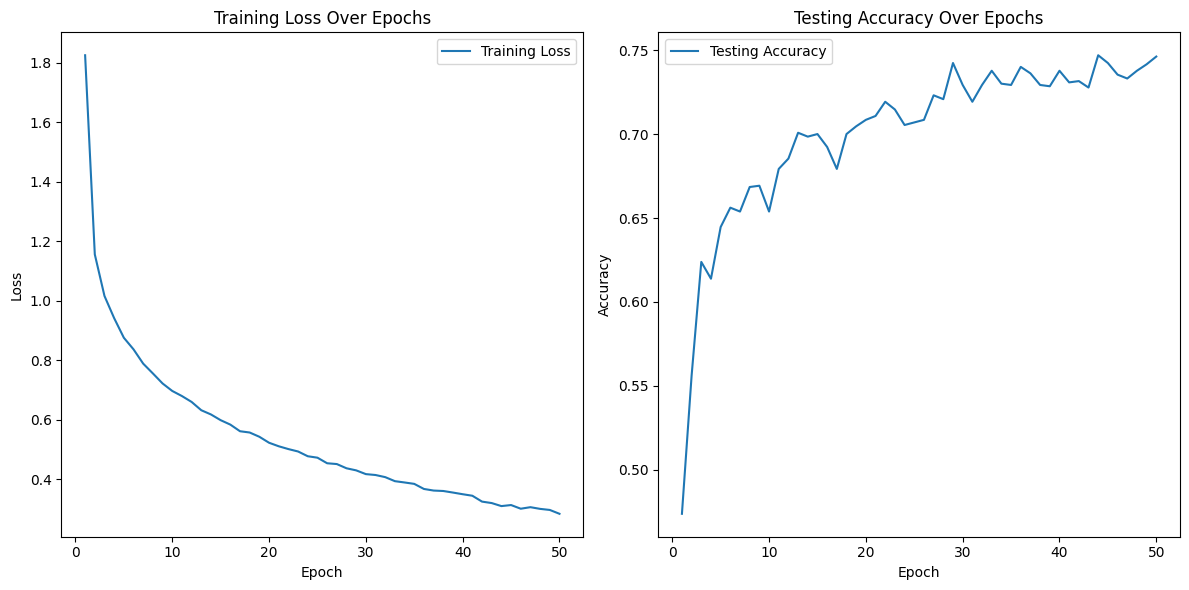

In [ ]:
plot_training_results(train_losses, test_accuracies)

In [ ]:
model_enhanced = EnhancedMultiClassNN(input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

enhanced_train_losses, enhanced_test_accuracies = train_and_evaluate_model(model_enhanced, train_loader, test_loader, num_epochs)

Epoch 1/50: Loss = 1.2872, Test Accuracy = 0.6169
Epoch 2/50: Loss = 0.9587, Test Accuracy = 0.6254
Epoch 3/50: Loss = 0.8589, Test Accuracy = 0.6554
Epoch 4/50: Loss = 0.8209, Test Accuracy = 0.6685
Epoch 5/50: Loss = 0.7627, Test Accuracy = 0.6846
Epoch 6/50: Loss = 0.7422, Test Accuracy = 0.6692
Epoch 7/50: Loss = 0.7105, Test Accuracy = 0.6892
Epoch 8/50: Loss = 0.6817, Test Accuracy = 0.6985
Epoch 9/50: Loss = 0.6570, Test Accuracy = 0.7077
Epoch 10/50: Loss = 0.6390, Test Accuracy = 0.7046
Epoch 11/50: Loss = 0.6303, Test Accuracy = 0.7154
Epoch 12/50: Loss = 0.6188, Test Accuracy = 0.6754
Epoch 13/50: Loss = 0.5983, Test Accuracy = 0.7062
Epoch 14/50: Loss = 0.5818, Test Accuracy = 0.7038
Epoch 15/50: Loss = 0.5642, Test Accuracy = 0.7108
Epoch 16/50: Loss = 0.5755, Test Accuracy = 0.7131
Epoch 17/50: Loss = 0.5489, Test Accuracy = 0.7062
Epoch 18/50: Loss = 0.5500, Test Accuracy = 0.7062
Epoch 19/50: Loss = 0.5250, Test Accuracy = 0.7077
Epoch 20/50: Loss = 0.5222, Test Accurac

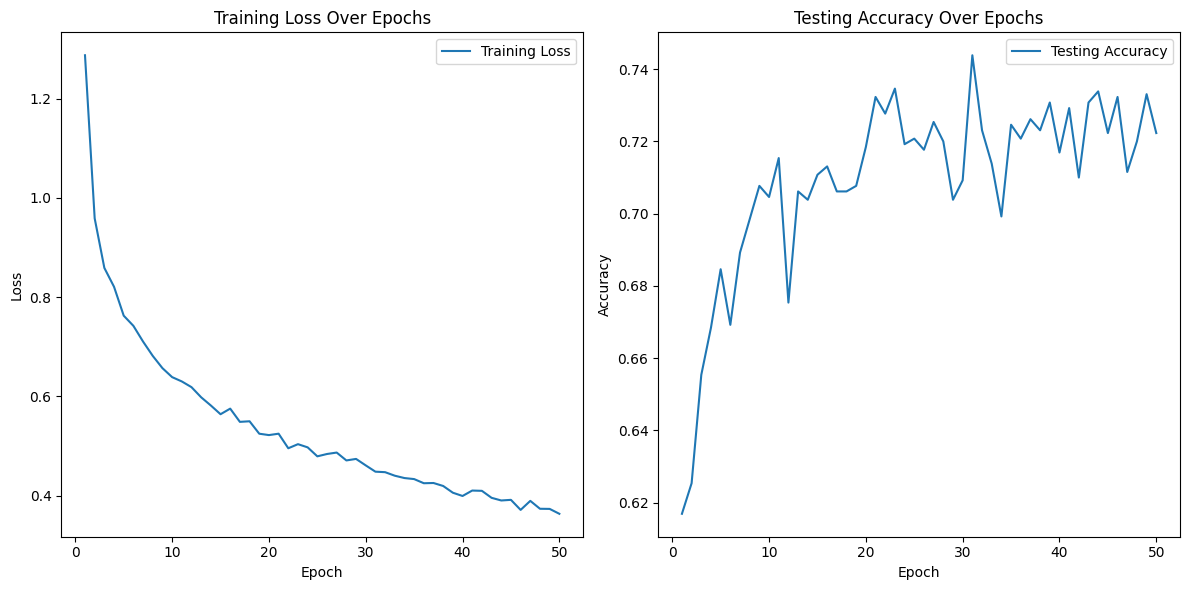

In [ ]:
plot_training_results(enhanced_train_losses, enhanced_test_accuracies)

In [ ]:
import torch.nn.functional as F
import torch, torch.nn as nn, torch.optim as optim

input_dim = AIME_embeddings.shape[1]  # Embedding dimension
num_classes = len(set(numerical_labels))  # Number of unique classes
model_improved = ImprovedMultiClassNN(input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_improved.parameters(), lr=0.001, weight_decay=1e-4)
num_epochs = 80

improved_train_losses, improved_test_accuracies = train_and_evaluate_model(model_improved, train_loader, test_loader, num_epochs)

Epoch 1/80: Loss = 1.4835, Test Accuracy = 0.6269
Epoch 2/80: Loss = 1.0102, Test Accuracy = 0.6792
Epoch 3/80: Loss = 0.8891, Test Accuracy = 0.6831
Epoch 4/80: Loss = 0.8249, Test Accuracy = 0.6923
Epoch 5/80: Loss = 0.7734, Test Accuracy = 0.7000
Epoch 6/80: Loss = 0.7286, Test Accuracy = 0.7077
Epoch 7/80: Loss = 0.7100, Test Accuracy = 0.6946
Epoch 8/80: Loss = 0.6730, Test Accuracy = 0.7277
Epoch 9/80: Loss = 0.6497, Test Accuracy = 0.7262
Epoch 10/80: Loss = 0.6308, Test Accuracy = 0.7208
Epoch 11/80: Loss = 0.6246, Test Accuracy = 0.7315
Epoch 12/80: Loss = 0.5902, Test Accuracy = 0.7208
Epoch 13/80: Loss = 0.5677, Test Accuracy = 0.7308
Epoch 14/80: Loss = 0.5708, Test Accuracy = 0.7185
Epoch 15/80: Loss = 0.5474, Test Accuracy = 0.7400
Epoch 16/80: Loss = 0.5390, Test Accuracy = 0.7346
Epoch 17/80: Loss = 0.5277, Test Accuracy = 0.7377
Epoch 18/80: Loss = 0.5153, Test Accuracy = 0.7338
Epoch 19/80: Loss = 0.4964, Test Accuracy = 0.7415
Epoch 20/80: Loss = 0.4905, Test Accurac

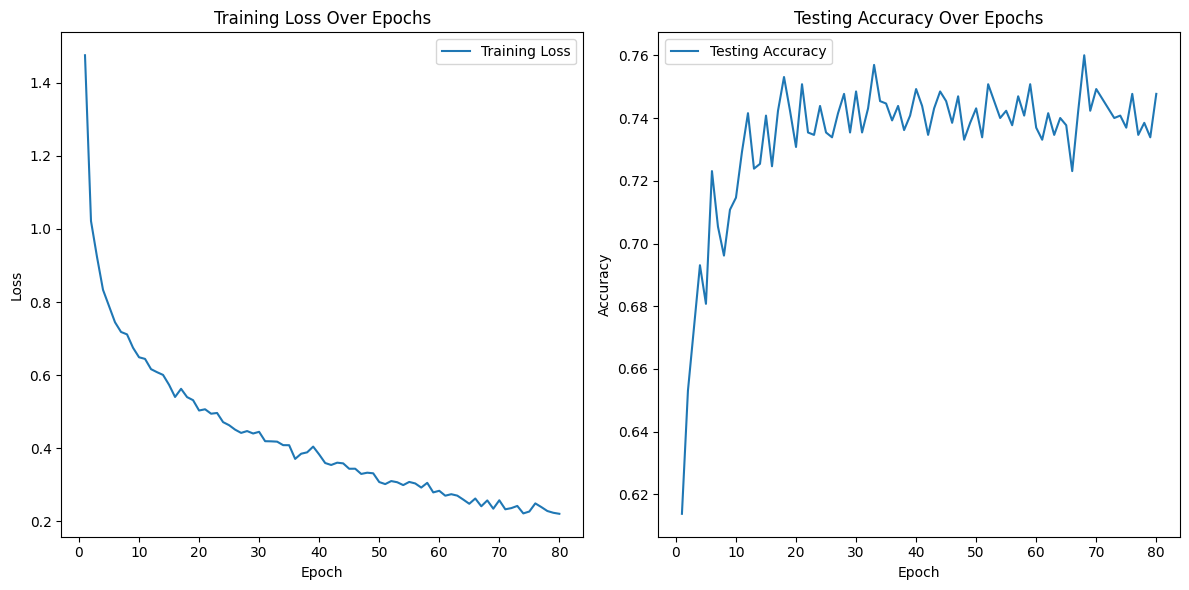

In [ ]:
plot_training_results(improved_train_losses, improved_test_accuracies)

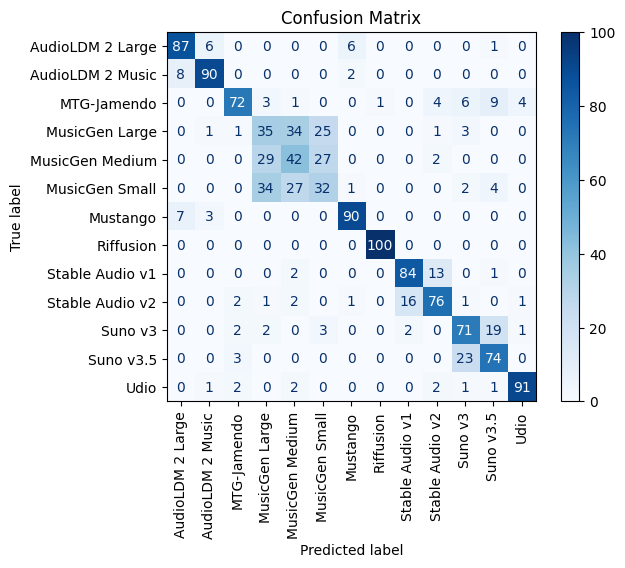


Classification Report:
                  precision    recall  f1-score   support

AudioLDM 2 Large       0.85      0.87      0.86       100
AudioLDM 2 Music       0.89      0.90      0.90       100
     MTG-Jamendo       0.88      0.72      0.79       100
  MusicGen Large       0.34      0.35      0.34       100
 MusicGen Medium       0.38      0.42      0.40       100
  MusicGen Small       0.37      0.32      0.34       100
        Mustango       0.90      0.90      0.90       100
       Riffusion       0.99      1.00      1.00       100
 Stable Audio v1       0.82      0.84      0.83       100
 Stable Audio v2       0.78      0.76      0.77       100
         Suno v3       0.66      0.71      0.69       100
       Suno v3.5       0.68      0.74      0.71       100
            Udio       0.94      0.91      0.92       100

        accuracy                           0.73      1300
       macro avg       0.73      0.73      0.73      1300
    weighted avg       0.73      0.73      0.7

In [ ]:
plot_confusion_matrix(model_improved, test_loader, label_encoder.classes_)

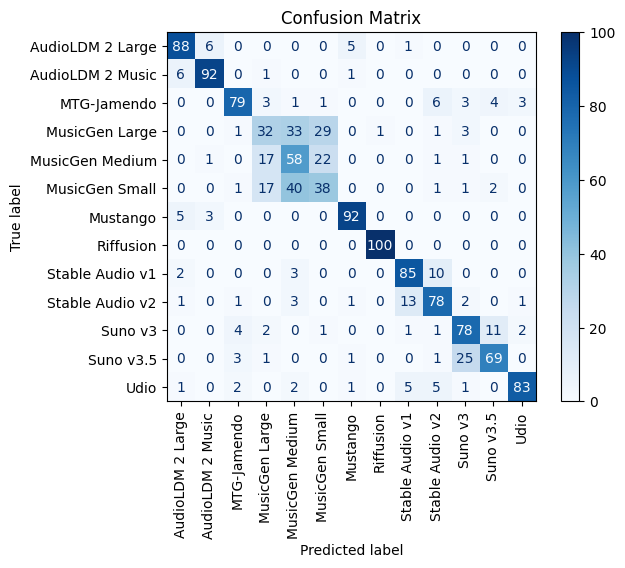


Classification Report:
                  precision    recall  f1-score   support

AudioLDM 2 Large       0.85      0.88      0.87       100
AudioLDM 2 Music       0.90      0.92      0.91       100
     MTG-Jamendo       0.87      0.79      0.83       100
  MusicGen Large       0.44      0.32      0.37       100
 MusicGen Medium       0.41      0.58      0.48       100
  MusicGen Small       0.42      0.38      0.40       100
        Mustango       0.91      0.92      0.92       100
       Riffusion       0.99      1.00      1.00       100
 Stable Audio v1       0.81      0.85      0.83       100
 Stable Audio v2       0.75      0.78      0.76       100
         Suno v3       0.68      0.78      0.73       100
       Suno v3.5       0.80      0.69      0.74       100
            Udio       0.93      0.83      0.88       100

        accuracy                           0.75      1300
       macro avg       0.75      0.75      0.75      1300
    weighted avg       0.75      0.75      0.7

In [ ]:
plot_confusion_matrix(model_improved, test_loader, label_encoder.classes_)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


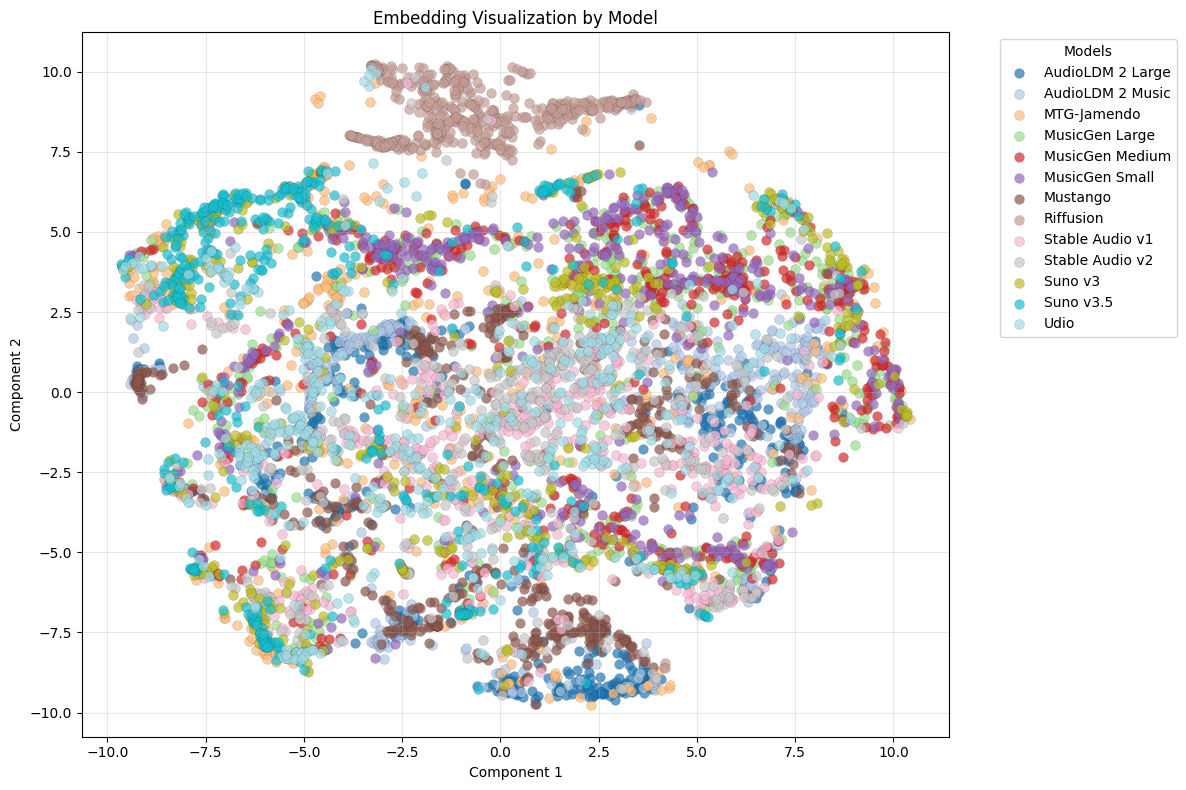

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

def visualize_embeddings_with_labels(embeddings, labels, class_names, method='pca', title="Embeddings Heatmap"):
    """
    Visualize embeddings using PCA or t-SNE and color by labels.

    Args:
        embeddings (numpy.ndarray): Array of embeddings (n_samples, n_features).
        labels (list or numpy.ndarray): Array of integer labels corresponding to embeddings.
        class_names (list): List of class names corresponding to label indices.
        method (str): Dimensionality reduction method ('pca' or 'tsne').
        title (str): Title of the plot.

    Returns:
        None: Displays the plot.
    """
    # Dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=2)
        reduced_embeddings = reducer.fit_transform(embeddings)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
        reduced_embeddings = reducer.fit_transform(embeddings)
    else:
        raise ValueError("Unsupported method. Choose 'pca' or 'tsne'.")

    # Convert numerical labels to colors
    unique_labels = np.unique(labels)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    # Plot
    plt.figure(figsize=(12, 8))
    for idx, label in enumerate(unique_labels):
        label_indices = np.where(labels == label)
        plt.scatter(
            reduced_embeddings[label_indices, 0],
            reduced_embeddings[label_indices, 1],
            label=class_names[label],
            color=colors[idx],
            alpha=0.7,  # Adjust transparency
            edgecolors='k',  # Black edge for clarity
            linewidth=0.1,
            s=50  # Increased marker size
        )

    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(loc="best", bbox_to_anchor=(1.05, 1), title="Models")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# Example Usage
# Replace `AIME_embeddings` and `numerical_labels` with your data
class_names = [
    "AudioLDM 2 Large", "AudioLDM 2 Music", "MTG-Jamendo", "MusicGen Large", "MusicGen Medium", "MusicGen Small",
    "Mustango", "Riffusion", "Stable Audio v1", "Stable Audio v2", "Suno v3", "Suno v3.5", "Udio"
]

visualize_embeddings_with_labels(
    embeddings=AIME_embeddings,
    labels=numerical_labels,
    class_names=class_names,
    method='tsne',  # Choose 'pca' or 'tsne'
    title="Embedding Visualization by Model"
)


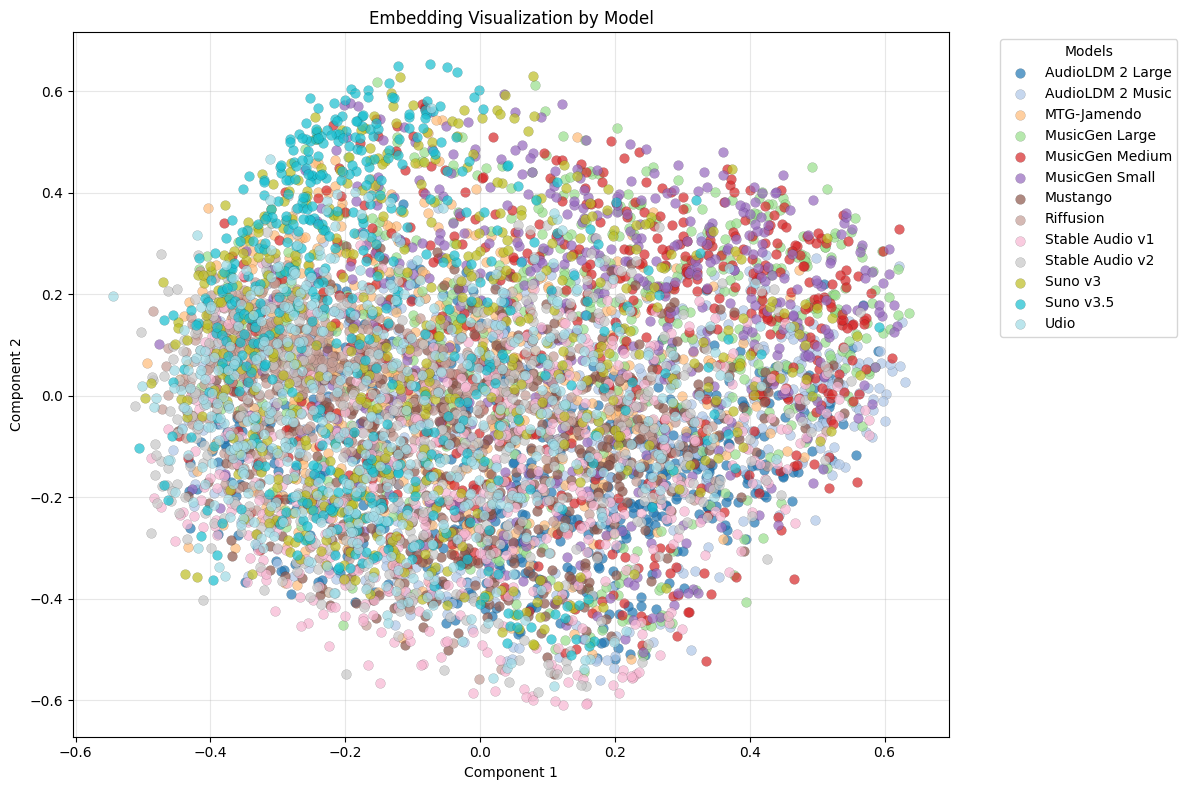

In [ ]:
visualize_embeddings_with_labels(
    embeddings=AIME_embeddings,
    labels=numerical_labels,
    class_names=class_names,
    method='pca',  # Choose 'pca' or 'tsne'
    title="Embedding Visualization by Model"
)

In [ ]:
torch.save(model_improved.state_dict(), f"/content/drive/MyDrive/MIT-Education/Junior Year/Music ML/Ananya-Kimaya Final Project/models/model_classifying/improved_model_epochs_{num_epochs}.pth")